# DESI PV Y1 Tempel Catalog VI
Generate cutouts to perform VI for the galaxies in the Y1 TFR calibration.  The goal is to remove observations that are contaminated by foreground stars, tidal effects, or other galaxies.

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.projections import get_projection_names

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab10').colors)

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

import ligo.skymap.plot

from scipy.spatial.distance import cdist, euclidean

import os

import itertools

from corner import corner

import pickle

from tqdm import tqdm

from desiutil.plots import init_sky

import requests

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,122.32238811543634,2.5088414493427758,N
55,SGA-2020 55,PGC120394

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [5]:
sum(ai_morphtab['Spiral_Pred'] == 'Spiral') + sum(ai_morphtab['Elliptical_Pred'] == 'Elliptical') + sum(ai_morphtab['Lenticular_Pred'] == 'Lenticular') + sum(ai_morphtab['Irregular_Pred'] == 'Irregular')

9710

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [6]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

# Combine ML morphtypes with SGA catalog

In [7]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max
'''
#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
'''
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

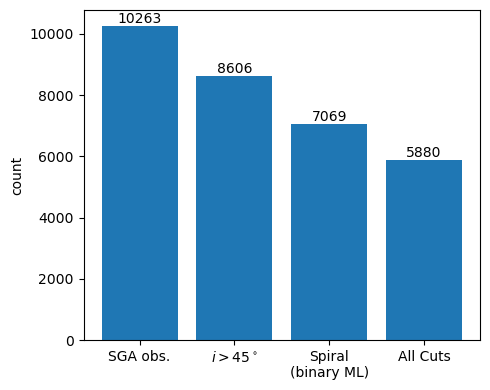

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [16]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [17]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [18]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [19]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [20]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [21]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

In [22]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [23]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_PRIMARY,MU_SECONDARY,MU_ERR,MU_SOURCE
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,str10,float64,float64,float64,float64,float64,bytes22
40926.0,SGA-2020 40926,PGC1068066,1068066,152.623449,-3.6906752,--,92.0,0.36307806,0.61659503,0.21329089,23.94848,17.52,False,LEDA-20181114,11069,PGC1068066,1,True,152.623449,-3.6906752,0.36307806,1525m037,152.62370459277508,-3.690698038306378,0.52914876,SB26,93.82398,0.6641905,152.623658987301,-3.690602374956275,13.956456,6.5563784,6.258357,5.964005,3.1641104,4.769187,6.5240216,8.290042,9.929943,11.569215,13.095884,14.571321,15.874463,18.975252,18.228054,17.692598,18.371702,17.647062,17.125422,17.974627,17.274006,16.773363,17.7288,17.050247,16.55726,17.57161,16.909569,16.427755,17.470478,16.816118,16.34705,17.408316,16.75774,16.293118,17.365652,16.719202,16.2552,17.339867,16.696472,16.233257,0.015255946,0.023526663,0.031296223,0.045312252,0.04817149,0.052810065,0.073413566,0.11950123,0.11073505,0.013739682,0.014882605,0.01610527,0.009548919,0.010457335,0.011346222,0.007930538,0.008566626,0.009396279,0.007392727,0.007950613,0.008675855,0.0071034827,0.0075082057,0.008207054,0.006730093,0.0070925383,0.007871118,0.0064921877,0.006838123,0.007653001,0.0063312803,0.006676669,0.0075182593,0.0062460634,0.0065811076,0.007477449,17.216694,0.5720894,0.84683824,2.769856,1.172794,16.567944,0.6329212,0.70157576,2.518496,1.1045564,16.112835,0.6603067,0.60

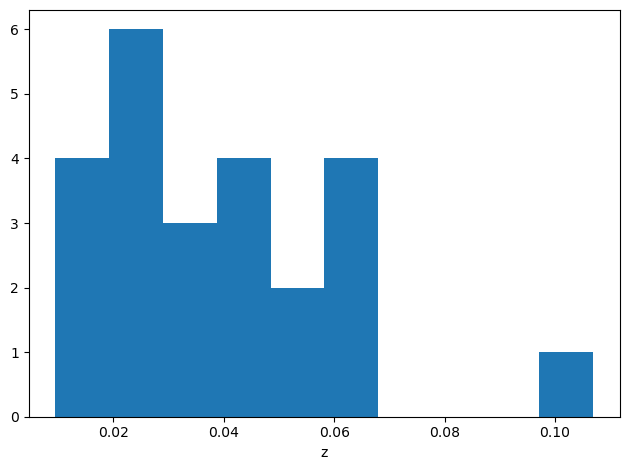

In [24]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [25]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [26]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=16>
      1999ac
      2001da
      2001ep
       2002G
      2005hc
      2006bw
      2007ba
      2010ai
      500038
 ASASSN-16ct
   AT2017cfc
     PS15cms
     PS16axi
     PS16ayd
     PS16bnz
   SN2017cjv,
 array([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 4, 1, 2, 2, 2, 1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

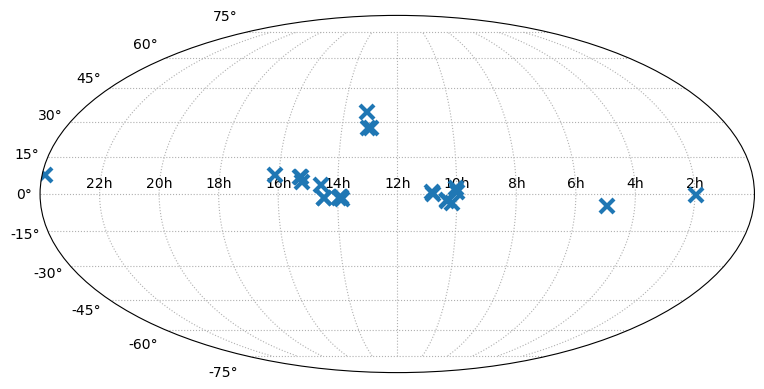

In [27]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

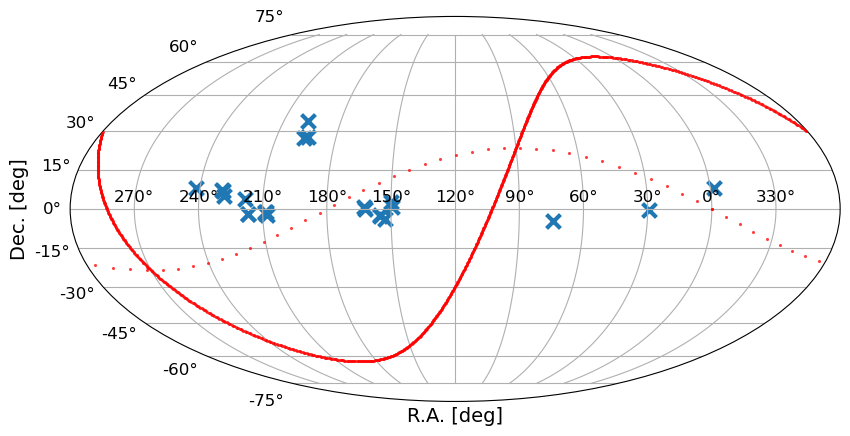

In [28]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y1/iron_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [29]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [30]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [31]:
# cluster table from Tempel.

clusters = Table.read('/global/homes/m/mjkeller/table1.dat', format = "ascii.no_header", names = ("GalID", "specID", "objID", "GroupID", "Ngal", "Rank", "Dist.g", "zobs", "zcmb", "e_zobs", "Dist", "Distcor", "RAdeg", "DEdeg", "GLON", "GLAT", "SGLON", "SGLAT", "lambda", "eta", "Xpos", "Ypos", "Zpos", "umag", "gmag", "rmag", "imag", "zmag", "uMAG", "gMAG", "rMAG", "iMAG", "zMAG", "k+e.u", "k+e.g", "k+e.r", "k+e.i", "k+e.z", "ext.u", "ext.g", "ext.r", "ext.i", "ext.z", "Lr", "w", "pE", "pS0", "pSa", "pSc", "Dist.e", "Den1", "Den2", "Den4", "Den8"))
print(len(clusters), 'galaxies')
clusters[:10]

584449 galaxies


GalID,specID,objID,GroupID,Ngal,Rank,Dist.g,zobs,zcmb,e_zobs,Dist,Distcor,RAdeg,DEdeg,GLON,GLAT,SGLON,SGLAT,lambda,eta,Xpos,Ypos,Zpos,umag,gmag,rmag,imag,zmag,uMAG,gMAG,rMAG,iMAG,zMAG,k+e.u,k+e.g,k+e.r,k+e.i,k+e.z,ext.u,ext.g,ext.r,ext.i,ext.z,Lr,w,pE,pS0,pSa,pSc,Dist.e,Den1,Den2,Den4,Den8
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,2552560286640924672,1237667108498440262,1,7,1,438.288185,0.10088736,0.101669636,1.8697e-05,438.804776,438.336385,122.060976235,16.369132777,206.201398985,24.164140163,56.644886856,-53.185360149,-58.696419344,0.348279091,374.526163,227.743328,1.384381,15.999198,15.184734,13.954014,14.183157,13.937554,-22.131911,-23.196076,-24.405571,-24.106044,-24.394216,-0.287705,-0.038004,-0.05923,-0.129613,-0.087044,0.147809,0.108757,0.078879,0.059812,0.042407,41.5172,1.697823,0.19025,0.43386,0.18794,0.18794,35.566085,597.16501638,91.39437291,21.91662205,8.91054125
297963,2552559736885110784,1237667108498440277,1,7,2,438.288185,0.101033255,0.101815006,2.1928e-05,439.416563,438.393468,122.020980121,16.360700637,206.19354466,24.125508179,56.596662602,-53.211992115,-58.734091325,0.369776339,374.724619,227.526124,1.468432,20.086974,18.167317,17.095039,16.649851,16.416131,-18.28905,-20.376015,-21.343928,-21.697949,-21.983936,-0.042789,0.124518,0.020153,-0.071014,-0.018746,0.144855,0.106583,0.077303,0.058616,0.04156,2.47498,1.697823,0.03965,0.61383,0.27964,0.06688,35.32141,576.03591785,91.74913354,22.18330172,8.95608821
314723,2552519879588603904,1237667142858899877,1,7,3,438.288185,0.10151869,0.102299513,1.7477e-05,441.455278,438.583691,121.985849724,16.422769183,206.116528794,24.11860931,56.495919555,-53.175311474,-58.733505737,0.505853207,374.884889,227.62455,2.009705,20.05769,18.096794,17.178307,16.755748,16.472958,-18.313511,-20.411608,-21.260102,-21.563896,-21.92021,-0.047612,0.089588,0.019595,-0.09917,-0.025646,0.14492,0.10663,0.077337,0.058642,0.041578,2.29108,1.697823,0.01026,0.05232,0.76391,0.17351,35.446809,473.40300902,85.29778122,21.4804246,8.8786183
381383,2552522628367673344,1237667142858899914,1,7,4,438.288185,0.10037472,0.101154935,2.5184e-05,436.638297,438.134241,121.975487764,16.49058534,206.043831309,24.135811281,56.424821448,-53.121649908,-58.709214307,0.629295763,374.404272,227.545178,2.499294,20.362229,18.494674,17.473126,16.984563,16.668633,-18.021644,-20.044971,-20.980751,-21.368719,-21.74594,-0.034941,0.120831,0.035063,-0.065533,-0.004241,0.156539,0.11518,0.083538,0.063344,0.044912,1.77133,1.697823,0.00692,0.02671,0.82561,0.14075,35.211785,326.81310144,76.8150851,21.43253206,8.89909769
408210,2552560561518831616,1237667142858899835,1,7,5,438.288185,0.09898493,0.099765387,2.2063e-05,430.786589,437.588245,121.947446172,16.394022935,206.129839415,24.073488887,56.466842501,-53.218671247,-58.77966768,0.491874461,374.21688,226.806983,1.947147,20.218531,18.470166,17.590959,17.18533,16.999678,-18.133518,-20.014456,-20.835365,-21.115845,-21.380781,-0.066765,0.065808,0.00751,-0.117638,-0.038355,0.147497,0.108527,0.078713,0.059686,0.042318,1.54934,1.697823,0.17803,0.56686,0.10969,0.14542,34.249144,316.76507418,83.71981379,23.69615532,9.20662148
409419,2552558362495576064,1237667108498440523,1,7,6,438.288185,0.101507574,0.102289125,2.1932e-05,441.411572,438.579613,122.004052761,16.353877572,206.193503329,24.107891077,56.578968758,-53.226067768,-58.751607703,0.37340246,374.953302,227.508022,1.482714,20.324769,18.480507,17.655746,17.305957,17.226434,-18.029211,-19.98554,-20.763287,-20.962716,-21.134855,-0.064834,0.047233,0.000219,-0.150141,-0.057524,0.144576,0.106377,0.077154,0.058503,0.04148,1.44982,1.697823,0.14079,0.65654,0.14832,0.0

In [32]:
cls_ids = np.unique(clusters['GalID'], return_counts = True)
print(len(cls_ids[0]))

cls_sufficient = []

# check for the number of groups with "enough" galaxies (more than 15) 
cls_plurality = np.extract(cls_ids[1]>5, cls_ids)
for i in range(len(cls_ids[1])): 
    if i in cls_plurality: 
        cls_sufficient.append(i)
print(len(cls_sufficient),'clusters') # this seems weird. 

584449
0 clusters


# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Ian Williams (2025, WIP).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [33]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA']*u.deg, sgatab_sel['DEC']*u.deg)
z_sga_desi = sgatab_sel['Z_DESI']
print(len(sgatab_sel), 'SGA galaxies')

5880 SGA galaxies


In [34]:
# match between Ian's catalog and the SGA galaxies
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 15

# Sky coordinates of Ian's galaxies
cls_coords = SkyCoord(clusters['RAdeg']*u.degree, clusters['DEdeg']*u.degree)

match_ids, match_dist, match_seps = sga_coords.match_to_catalog_sky(cls_coords)
match_sep = match_seps*3600 #convert to arcsec

print(len(match_ids), "SGA galaxies in Tempel catalog")

5880 SGA galaxies in Tempel catalog


Text(0, 0.5, 'count')

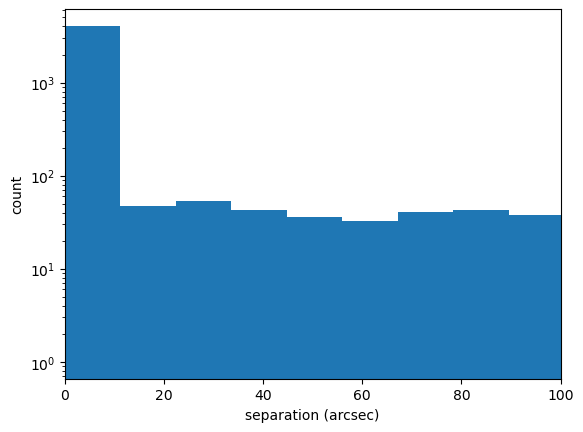

In [35]:
# make a histogram of separations between Ian's galaxies and the SGA galaxies they matched with above
plt.xlim(-1/10000,100)
plt.hist(match_sep, bins = 500)
plt.yscale('log')
# plt.axvline(x=(12), color = 'k')
plt.xlabel("separation (arcsec)")
plt.ylabel("count")

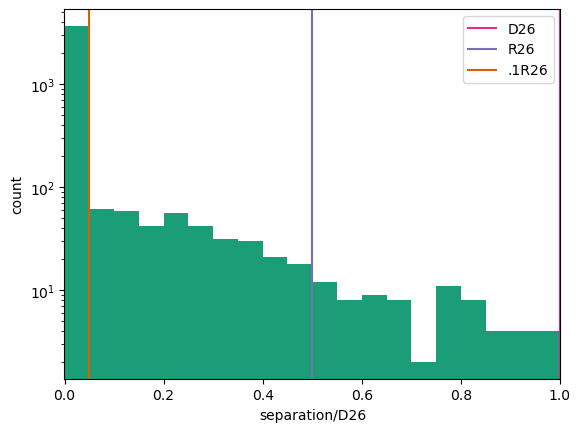

In [36]:
colors = plt.get_cmap('Dark2').colors

# make the same histogram, but normalized by D26 in degrees 

D26_deg = 60*sgatab_sel['D26']
norm_sep = []
for i in range(len(match_sep)): 
    norm_i = match_sep[i]/(.5*D26_deg[i])
    norm_sep.append(norm_i.value)

plt.hist(norm_sep, bins = np.arange(0,1.5,.05), color = colors[0])
plt.xlim(-1/10000,1.001)
plt.axvline(x=1, color = colors[3], label = "D26")
plt.axvline(x=.5, color = colors[2], label = "R26")
plt.axvline(x=.05, color = colors[1], label = ".1R26")
plt.yscale('log')
plt.ylabel("count")
plt.xlabel("separation/D26")
plt.legend()

In [37]:
max_sep = .25*1/300
constraint = match_sep < max_sep
match_galaxies = sga_coords[constraint]

In [43]:
counts_sep, limits_sep = np.histogram(match_sep, bins = np.arange(0,1.5, .05))

print('Bin 0:', counts_sep[0], 'galaxies, maximum separation of', limits_sep[1], "arcsec")
print('Bin 1:', counts_sep[1], 'galaxies, maximum separation of', limits_sep[2], "arcsec")
print('Bin 2:', counts_sep[2], 'galaxies, maximum separation of', limits_sep[3], "arcsec")
print('Bin 3:', counts_sep[3], 'galaxies, maximum separation of', limits_sep[4], "arcsec")
print('Bin 4:', counts_sep[4], 'galaxies, maximum separation of', limits_sep[5], "arcsec")

Bin 0: 3615 galaxies, maximum separation of 0.05 arcsec
Bin 1: 5 galaxies, maximum separation of 0.1 arcsec
Bin 2: 2 galaxies, maximum separation of 0.15000000000000002 arcsec
Bin 3: 2 galaxies, maximum separation of 0.2 arcsec
Bin 4: 0 galaxies, maximum separation of 0.25 arcsec


In [44]:
counts_norm, limits_norm = np.histogram(norm_sep, bins = np.arange(0,10,.05))

print('Bin 0:', counts_norm[0], 'galaxies, maximum separation of', 2*limits_norm[1], "R26")
print('Bin 1:', counts_norm[1], 'galaxies, maximum separation of', 2*limits_norm[2], "R26")
print('Bin 2:', counts_norm[2], 'galaxies, maximum separation of', 2*limits_norm[3], "R26")
print('Bin 3:', counts_norm[3], 'galaxies, maximum separation of', 2*limits_norm[4], "R26")

Bin 0: 3675 galaxies, maximum separation of 0.1 R26
Bin 1: 61 galaxies, maximum separation of 0.2 R26
Bin 2: 59 galaxies, maximum separation of 0.30000000000000004 R26
Bin 3: 42 galaxies, maximum separation of 0.4 R26


In [54]:
# pull out separations based on edge quantities in each histogram bin 

sep = [item for item in norm_sep if limits_norm[3] < item < limits_norm[4]]
print(len(sep))

# pull out a "reasonable" number of targets to VI 
vi_sep_quantity = sep[0::2]

vi_seps = []
for i in range(len(vi_sep_quantity)): 
    n_smallsep = float(vi_sep_quantity[i])
    vi_seps.append(n_smallsep)

# get the list of indices for the selections from the first bin of the histogram
vi_indices = []
for i in tqdm(range(len(vi_seps))): 
    index = list(norm_sep).index(vi_seps[i])
    vi_indices.append(index)
print(len(vi_indices))

42


100%|██████████| 21/21 [00:00<00:00, 3926.38it/s]

21


In [55]:
def get_cutout(sgaid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    sgaid : int
        SGA galaxy ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/sga_{}.jpg'.format(sgaid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [56]:
# un-comment this to run VI again.

for i in vi_indices: 
    # Retrieve SGA ID of galaxy
    sga_id = match_ids[i]
    print(sga_id)
    
    # Coordinates of SGA galaxy's center   
    center = cls_coords[i]
    string_center = center.to_string(decimal = True) 
    center_coords = string_center.split()
    ra, dec = float(center_coords[0]), float(center_coords[1])
    print(ra, dec)
    
    # D26 in arcmin
    d26  = sgatab_sel['D26'][i]
    print(d26)
    
    #---------------------------------------------------------------------------
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
    img_file, wcs = get_cutout(sga_id, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))
    
    ax = fig1.add_subplot(1, 1, 1, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.plot(ra, dec, color = "red", markersize = 30)
    ax.set(xlabel='ra', ylabel='dec')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')

    r2 = SphericalCircle((ra * u.deg, dec * u.deg), .001*d26*60*u.arcsec, edgecolor='red', facecolor='none', transform=ax.get_transform('icrs'))

    ax.add_patch(r2)
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)

334841
239.318 27.678
0.47552624
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=239.318&dec=27.678&zoom=14&layer=ls-dr9&size=111&sga
536438
225.066 23.2013
0.6298982
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=225.066&dec=23.2013&zoom=14&layer=ls-dr9&size=147&sga
403919
231.864 28.8079
0.46822557
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=231.864&dec=28.8079&zoom=14&layer=ls-dr9&size=109&sga
509537
231.972 28.785
1.4172151
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=231.972&dec=28.785&zoom=14&layer=ls-dr9&size=332&sga
240089
230.803 30.9212
0.5287175
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=230.803&dec=30.9212&zoom=14&layer=ls-dr9&size=124&sga
431835
173.852 13.5907
1.5007156
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=173.852&dec=13.5907&zoom=14&layer=ls-dr9&size=352&sga
251343
236.795 33.146
0.72093993
Get https://www.legacysurvey.org/viewer/cutout.jpg?ra=236.795&dec=33.146&zoom=14&layer=ls-dr9&size=169&sga
403557
215.3 48.

In [ ]:
# pull out separations based on edge quantity of largest included histogram bin 

sep = [item for item in norm_sep if 0 < item < limits_norm[2]]
print(len(sep))

# get the list of indices for the first bin of the histogram
indices = []
for i in tqdm(range(len(sep))): 
    index = list(norm_sep).index(sep[i])
    indices.append(index)
print(len(indices))